Universal World Bank-style visualizer (uses files in /mnt/data or upload)
-----------------------------------------------------------------------
No World Bank-like file found in /mnt/data. Do you want to upload one? (yes/no): yes
Please upload the World Bank CSV (time-series) file:


Saving API_SP.POP.TOTL_DS2_en_csv_v2_280659.csv to API_SP.POP.TOTL_DS2_en_csv_v2_280659 (1).csv
Saving Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_280659.csv to Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_280659 (1).csv
Saving Metadata_Indicator_API_SP.POP.TOTL_DS2_en_csv_v2_280659.csv to Metadata_Indicator_API_SP.POP.TOTL_DS2_en_csv_v2_280659 (1).csv
✔ Uploaded: API_SP.POP.TOTL_DS2_en_csv_v2_280659 (1).csv

Detected year / numeric columns (first 8 shown): ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967'] ...
Default (latest) year selected: 2024
Enter a year column to use for distribution plots (press Enter to use 2024): 

Preparing plots for: Population, total — year/column: 2024
Number of rows with numeric values for this column: 265

Generating charts: histogram, bar (top countries), pie (top countries), and time-series for top countries.



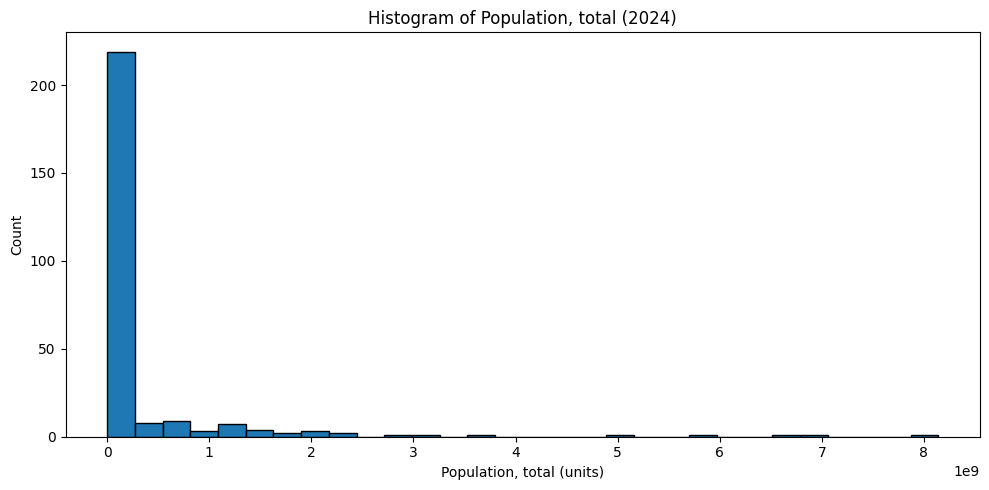

<Figure size 640x480 with 0 Axes>

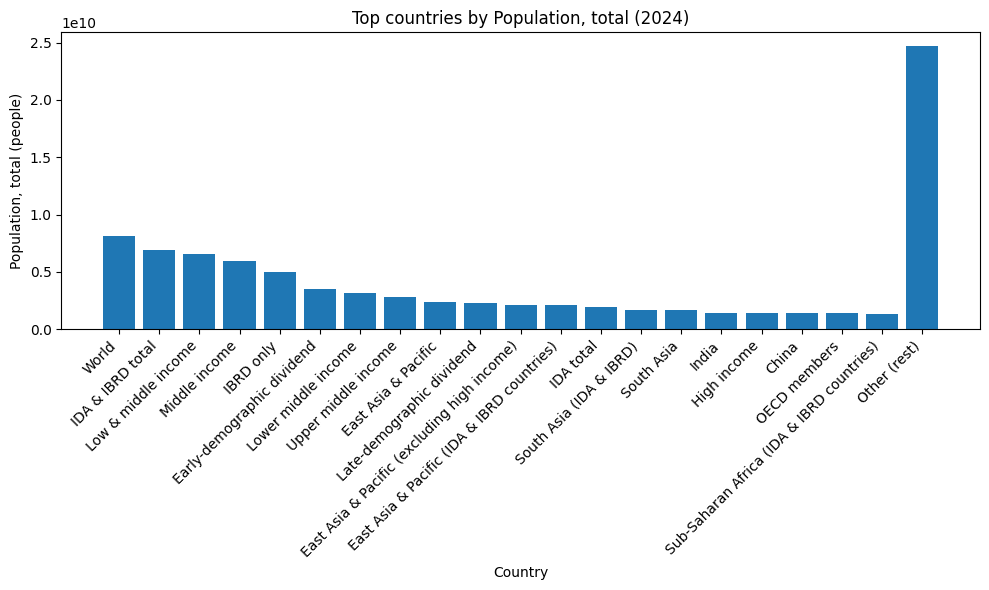

<Figure size 640x480 with 0 Axes>

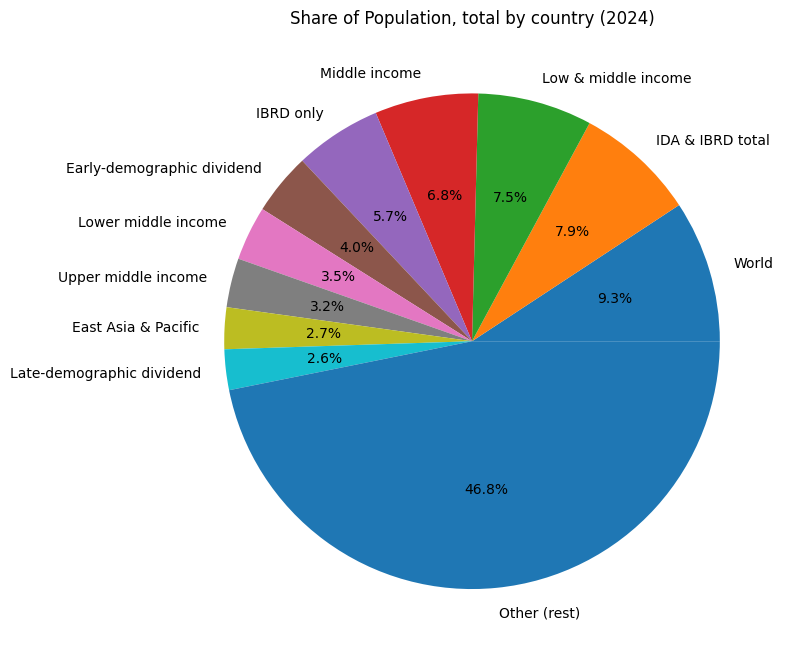

Now plotting time-series for top countries across available years.


<Figure size 640x480 with 0 Axes>

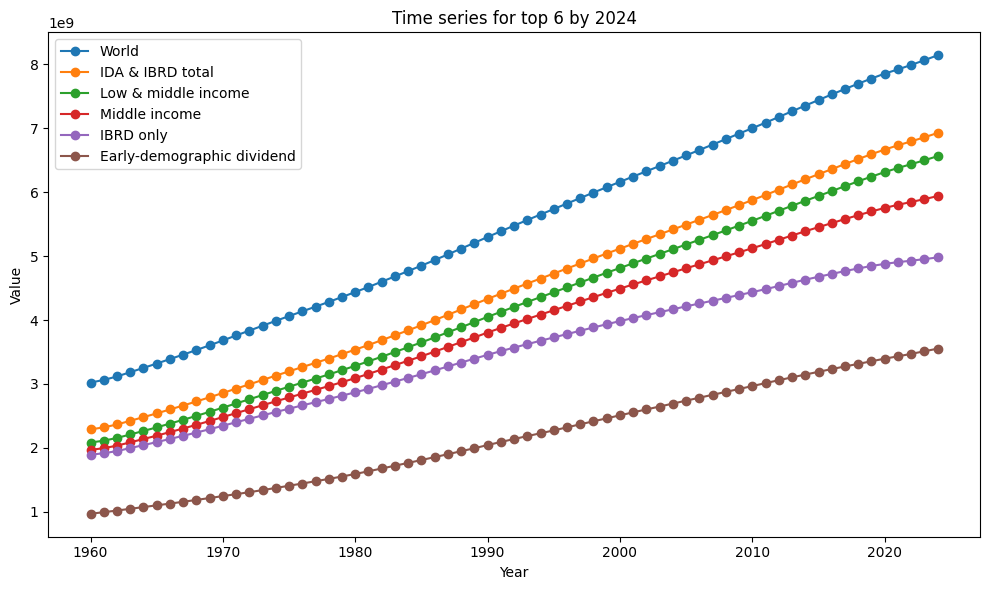


✅ All done. If you want different choices (different year, different top-N values, or to save plots to files), tell me and I'll update the script.


<Figure size 640x480 with 0 Axes>

In [2]:
# Colab-ready visualizer for World Bank-style time-series CSVs + metadata
# - Detects files in /mnt/data or lets you upload
# - Uses metadata files (if present) to label charts
# - Auto-generates histogram, bar, pie, and time-series plots for the chosen year
# - No Age/Gender/Area assumptions (works with whatever numeric year columns exist)
try:
    import matplotlib.pyplot as plt
except ImportError:
    import subprocess, sys
    print("matplotlib not found. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
    import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
from google.colab import files
import math

# ---------------------------
# Helpers
# ---------------------------
def safe_show_and_clear():
    plt.tight_layout()
    plt.show()
    plt.clf()

def find_file_in_mnt(startswith):
    """Return first file path in /mnt/data that starts with given string (or None)."""
    d = "/mnt/data"
    if not os.path.isdir(d):
        return None
    for fn in os.listdir(d):
        if fn.startswith(startswith):
            return os.path.join(d, fn)
    return None

def upload_csv_colab(prompt="Upload a CSV file"):
    print(prompt)
    uploaded = files.upload()
    if uploaded:
        name = list(uploaded.keys())[0]
        print(f"✔ Uploaded: {name}")
        return name
    return None

def is_world_bank_csv(path):
    """Quick check if CSV looks like World Bank time-series format."""
    try:
        df_try = pd.read_csv(path, skiprows=4, nrows=2)
        cols_lower = [c.lower() for c in df_try.columns]
        return ("country name" in cols_lower) or ("country code" in cols_lower) or ("indicator name" in cols_lower)
    except Exception:
        return False

def load_world_bank_csv(path):
    """Load World Bank CSV and return DataFrame (skips metadata header rows)."""
    df = pd.read_csv(path, skiprows=4)
    # drop any fully-empty columns
    df = df.loc[:, df.columns.notnull()]
    return df

def pick_year_columns(df):
    """Return list of columns that look like years (4-digit numeric names)."""
    year_cols = [c for c in df.columns if isinstance(c, str) and c.strip().isdigit() and len(c.strip())==4]
    # ensure sorted
    year_cols_sorted = sorted(year_cols, key=lambda x: int(x))
    return year_cols_sorted

def format_big_number(x):
    """Return human-friendly string for large numbers."""
    if pd.isna(x):
        return ""
    try:
        x = float(x)
    except Exception:
        return str(x)
    # use SI-ish formatting
    if abs(x) >= 1e9:
        return f"{x/1e9:.2f}B"
    if abs(x) >= 1e6:
        return f"{x/1e6:.2f}M"
    if abs(x) >= 1e3:
        return f"{x/1e3:.2f}K"
    return f"{x:.0f}"

# ---------------------------
# Plotting functions
# ---------------------------
def plot_histogram_numeric(series, title, xlabel, ylabel="Count", bins=30):
    vals = pd.to_numeric(series, errors='coerce').dropna()
    if vals.empty:
        print("No numeric data available for histogram.")
        return
    plt.figure(figsize=(10,5))
    plt.hist(vals, bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    safe_show_and_clear()

def plot_barchart_top(df_labels, df_values, title, xlabel, ylabel="Value", top_n=20):
    if df_values.empty:
        print("No values to plot for bar chart.")
        return
    # df_labels: list-like of labels; df_values: numeric series aligned
    s = pd.Series(df_values.values, index=df_labels).dropna()
    if s.empty:
        print("No non-null values for bar chart.")
        return
    s_sorted = s.sort_values(ascending=False)
    if len(s_sorted) > top_n:
        top = s_sorted.iloc[:top_n].copy()
        other_sum = s_sorted.iloc[top_n:].sum()
        top["Other (rest)"] = other_sum
        s_plot = top
    else:
        s_plot = s_sorted
    plt.figure(figsize=(max(10, len(s_plot)*0.4),6))
    plt.bar(s_plot.index, s_plot.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    safe_show_and_clear()

def plot_pie_top(df_labels, df_values, title, top_n=10):
    s = pd.Series(df_values.values, index=df_labels).dropna()
    if s.empty:
        print("No values to plot for pie chart.")
        return
    s_sorted = s.sort_values(ascending=False)
    if len(s_sorted) > top_n:
        top = s_sorted.iloc[:top_n].copy()
        other_sum = s_sorted.iloc[top_n:].sum()
        top["Other (rest)"] = other_sum
        s_plot = top
    else:
        s_plot = s_sorted
    plt.figure(figsize=(8,8))
    plt.pie(s_plot.values, labels=s_plot.index, autopct="%1.1f%%")
    plt.title(title)
    safe_show_and_clear()

def plot_timeseries_for_top(df, years, label_col, value_cols, top_n=5):
    """
    df: DataFrame with label_col and year columns (value_cols list).
    plots time series for the top_n labels by latest year value.
    """
    latest_col = value_cols[-1]  # assuming value_cols sorted ascending
    temp = df[[label_col] + value_cols].copy()
    temp[latest_col] = pd.to_numeric(temp[latest_col], errors='coerce')
    temp = temp.dropna(subset=[latest_col])
    if temp.empty:
        print("No time-series data available (no numeric latest-year values).")
        return
    top_labels = temp.sort_values(by=latest_col, ascending=False).head(top_n)[label_col].tolist()
    # prepare long-format series per label
    plt.figure(figsize=(10,6))
    for lbl in top_labels:
        row = temp[temp[label_col]==lbl]
        if row.empty:
            continue
        y = row[value_cols].iloc[0].astype(float).values
        x = [int(yc) for yc in value_cols]
        plt.plot(x, y, marker='o', label=lbl)
    plt.title(f"Time series for top {len(top_labels)} by {latest_col}")
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.legend()
    safe_show_and_clear()

# ---------------------------
# Main flow
# ---------------------------
print("Universal World Bank-style visualizer (uses files in /mnt/data or upload)")
print("-----------------------------------------------------------------------")

# try to detect main CSV and metadata files already present
wb_main = find_file_in_mnt("API_SP.POP.TOTL") or find_file_in_mnt("API_")
meta_country = find_file_in_mnt("Metadata_Country") or find_file_in_mnt("Metadata_Country_")
meta_indicator = find_file_in_mnt("Metadata_Indicator") or find_file_in_mnt("Metadata_Indicator_")

data_path = None
df_wb = None
meta_country_df = None
meta_indicator_df = None

if wb_main:
    print(f"Found candidate World Bank file: {wb_main}")
    if is_world_bank_csv(wb_main):
        data_path = wb_main
        print("Detected as World Bank-style CSV.")
    else:
        # if file exists but not clearly WB format, still allow using it
        data_path = wb_main
        print("File present but not clearly World Bank format; attempting to read.")
else:
    # ask upload
    uploaded = input("No World Bank-like file found in /mnt/data. Do you want to upload one? (yes/no): ").strip().lower()
    if uploaded == "yes":
        fname = upload_csv_colab("Please upload the World Bank CSV (time-series) file:")
        if fname:
            data_path = fname

# load metadata files if present (optional)
if meta_country:
    try:
        meta_country_df = pd.read_csv(meta_country)
        print(f"Loaded country metadata: {meta_country}")
    except Exception as e:
        print(f"Failed to load country metadata ({meta_country}): {e}")
if meta_indicator:
    try:
        meta_indicator_df = pd.read_csv(meta_indicator)
        print(f"Loaded indicator metadata: {meta_indicator}")
    except Exception as e:
        print(f"Failed to load indicator metadata ({meta_indicator}): {e}")

# load main data
if not data_path:
    raise SystemExit("No data file provided - stopping.")

try:
    df_wb = load_world_bank_csv(data_path)
except Exception as e:
    raise SystemExit(f"Failed to load main CSV: {e}")

# try to discover useful label columns (common WB columns)
label_col_candidates = [c for c in df_wb.columns if c.lower() in ("country name", "country", "countryname", "country_name")]
label_col = label_col_candidates[0] if label_col_candidates else df_wb.columns[0]

indicator_name_col = None
for cname in df_wb.columns:
    if cname.lower() in ("indicator name", "indicator_name", "indicatorname"):
        indicator_name_col = cname
        break

# find year columns
year_cols = pick_year_columns(df_wb)
if not year_cols:
    # fallback: find columns with many numeric-like values
    numeric_like = []
    for c in df_wb.columns:
        # skip known string columns
        if c in (label_col, indicator_name_col):
            continue
        # test convertibility
        series = pd.to_numeric(df_wb[c], errors='coerce')
        non_null_frac = series.notna().mean()
        if non_null_frac > 0.2:
            numeric_like.append(c)
    year_cols = numeric_like

if not year_cols:
    raise SystemExit("No year or numeric-like columns detected in the provided CSV.")

# choose a default year (latest), allow user override
default_year = year_cols[-1]
print("\nDetected year / numeric columns (first 8 shown):", year_cols[:8], "...")
print(f"Default (latest) year selected: {default_year}")
year_choice = input(f"Enter a year column to use for distribution plots (press Enter to use {default_year}): ").strip()
if year_choice == "":
    year_choice = default_year
if year_choice not in df_wb.columns:
    print(f"Warning: chosen year '{year_choice}' not found as column. Attempting to coerce to nearest match.")
    # try to match digits
    if year_choice.isdigit():
        matches = [c for c in df_wb.columns if str(c).strip()==year_choice]
        if matches:
            year_choice = matches[0]
        else:
            print("No matching year column found. Using default.")
            year_choice = default_year
    else:
        print("No matching year column found. Using default.")
        year_choice = default_year

# get indicator label if present
indicator_label = df_wb[indicator_name_col].iloc[0] if indicator_name_col else os.path.basename(data_path)
if meta_indicator_df is not None and not meta_indicator_df.empty:
    # if indicator meta matches, try to find nicer label
    try:
        # some metadata files use columns like 'Indicator Code' and 'Indicator Name'
        if 'Indicator Name' in meta_indicator_df.columns:
            indicator_label = meta_indicator_df['Indicator Name'].iloc[0]
    except Exception:
        pass

# prepare series for plotting
labels = df_wb[label_col].astype(str)
values = pd.to_numeric(df_wb[year_choice], errors='coerce')

# report basic stats
valid_count = values.notna().sum()
print(f"\nPreparing plots for: {indicator_label} — year/column: {year_choice}")
print(f"Number of rows with numeric values for this column: {valid_count}")

# Auto-generate multiple charts
print("\nGenerating charts: histogram, bar (top countries), pie (top countries), and time-series for top countries.\n")

# 1) histogram
plot_histogram_numeric(values, title=f"Histogram of {indicator_label} ({year_choice})", xlabel=f"{indicator_label} (units)")

# 2) bar chart (top N)
plot_barchart_top(labels, values, title=f"Top countries by {indicator_label} ({year_choice})", xlabel="Country", ylabel=f"{indicator_label} (people)", top_n=20)

# 3) pie chart (top M)
plot_pie_top(labels, values, title=f"Share of {indicator_label} by country ({year_choice})", top_n=10)

# 4) time-series for top K countries (use all detected year columns)
print("Now plotting time-series for top countries across available years.")
years_for_ts = year_cols  # already sorted ascending
plot_timeseries_for_top(df_wb, years_for_ts, label_col=label_col, value_cols=years_for_ts, top_n=6)

print("\n✅ All done. If you want different choices (different year, different top-N values, or to save plots to files), tell me and I'll update the script.")
